# COMP4318/COMP5318 Assignment 2

In this template, we have provided data loading code and section headings to help structure your notebook. Please refer to the assignment specification pdf to guide the content of your notebook and report.


(Add SIDs here)

520594771

530724087

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [2]:
# Please include your imports in this cell
import numpy as np
import pandas as pd

!pip install scikeras

import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier # Random Forests
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC # Linear SVM

# Data loading, exploration, and preprocessing

## Data loading

In [3]:
# Load data files assuming Assignment2Data folder
# is present in the same directory as the notebook
X_train = np.load('/content/drive/MyDrive/Assignment2Data/X_train.npy')
y_train = np.load('/content/drive/MyDrive/Assignment2Data/y_train.npy')
X_test = np.load('/content/drive/MyDrive/Assignment2Data/X_test.npy')
y_test = np.load('/content/drive/MyDrive/Assignment2Data/y_test.npy')

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13673, 28, 28, 3) (3419, 28, 28, 3) (13673,) (3419,)


## Data exploration

Class Imbalance

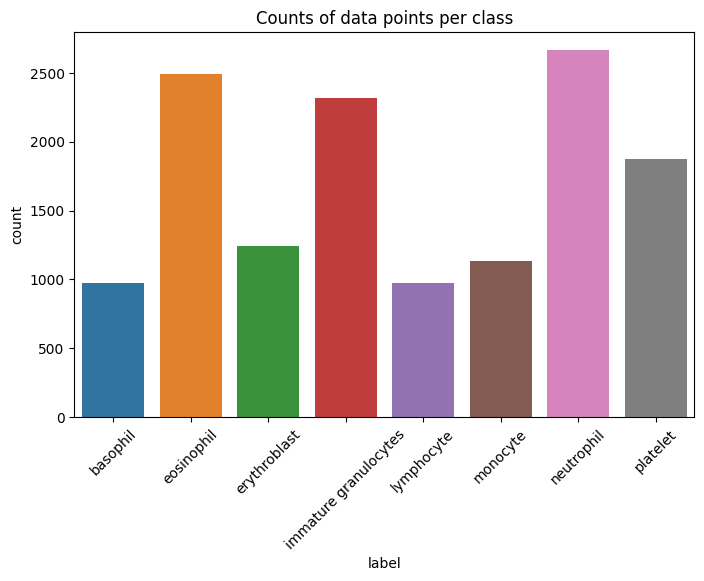

In [7]:
import seaborn as sns

y_train = pd.DataFrame(y_train)
label_map = {0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3: 'immature granulocytes', 4: 'lymphocyte', 5: 'monocyte', 6: 'neutrophil', 7: 'platelet'}

plt.figure(figsize=(8, 5))
plt.title('Counts of data points per class')

# 使用y_train绘制计数图
sns.countplot(x=y_train.iloc[:, 0])

# 使用标签映射更新x轴标签
old_xaxis = list(label_map.keys())
new_axis = list(label_map.values())
plt.xticks(old_xaxis, new_axis, rotation=45)
plt.xlabel('label')
plt.show()

t-SNE

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 将图像平铺为一维向量
X_train_flattened = np.array([x.flatten() for x in X_train])

# 使用 t-SNE 对降维后的数据进行降维到2维
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state = 0, verbose=1)
X_train_tsne = tsne.fit_transform(X_train_flattened)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13673 samples in 0.011s...
[t-SNE] Computed neighbors for 13673 samples in 8.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13673
[t-SNE] Computed conditional probabilities for sample 2000 / 13673
[t-SNE] Computed conditional probabilities for sample 3000 / 13673
[t-SNE] Computed conditional probabilities for sample 4000 / 13673
[t-SNE] Computed conditional probabilities for sample 5000 / 13673
[t-SNE] Computed conditional probabilities for sample 6000 / 13673
[t-SNE] Computed conditional probabilities for sample 7000 / 13673
[t-SNE] Computed conditional probabilities for sample 8000 / 13673
[t-SNE] Computed conditional probabilities for sample 9000 / 13673
[t-SNE] Computed conditional probabilities for sample 10000 / 13673
[t-SNE] Computed conditional probabilities for sample 11000 / 13673
[t-SNE] Computed conditional probabilities for sample 12000 / 13673
[t-SNE] Computed conditional probabilities for sam

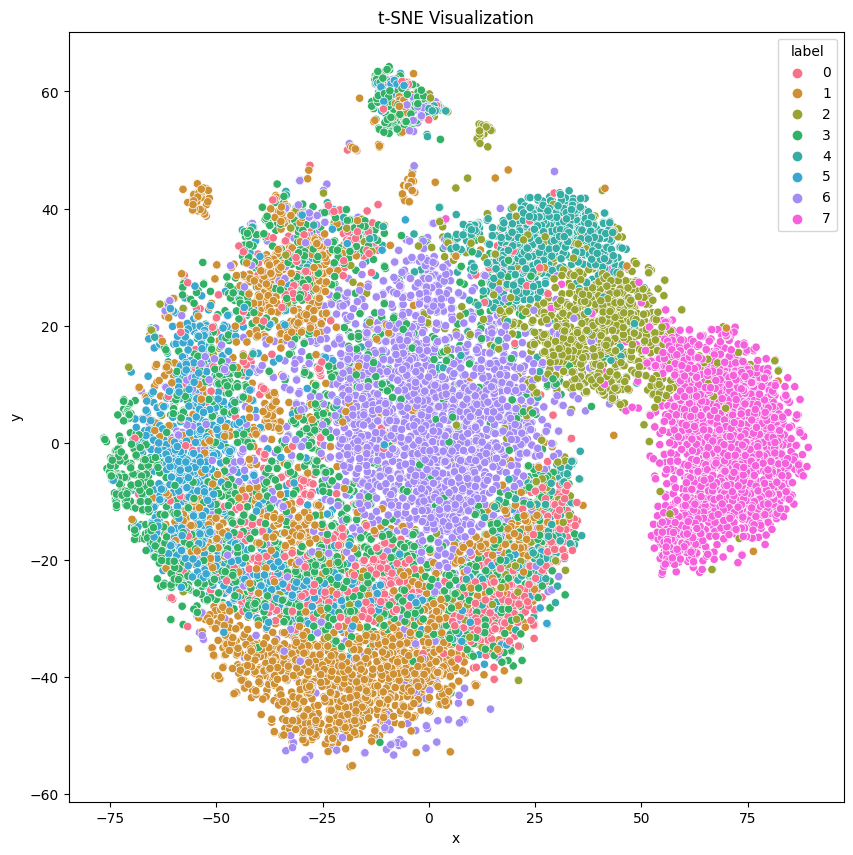

In [9]:

df_tsne = pd.DataFrame(columns=["x", "y", "label"])
df_tsne["x"] = X_train_tsne[:, 0]
df_tsne["y"] = X_train_tsne[:, 1]
df_tsne["label"] = y_train

plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="label", palette=sns.color_palette("husl", 8))
plt.title('t-SNE Visualization')
plt.show()

## Preprocessing

In [4]:
# Normalisation: scale the data to the range 0-1
max_value = np.max(X_train)
print(max_value)

X_train_norm = X_train / 255
X_test_norm = X_test / 255

255


In [15]:
X_train_norm.shape

(13673, 28, 28, 3)

In [5]:
# Input preprocessing for MLP - 3 dimension
X_train_3d = np.sum(X_train_norm, axis = 3)
X_test_3d = np.sum(X_test_norm, axis = 3)

In [26]:
X_train_3d.shape

(13673, 28, 28)

In [6]:
# Input preprocessing for CNN - 4 dimension

X_train_4d = X_train_norm
X_test_4d = X_test_norm

In [18]:
X_train_4d.shape

(13673, 28, 28, 3)

In [42]:
# Input preprocessing for Random Forest and SVM - 2 dimension without PCA
X_train_RF = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_RF = X_test_norm.reshape(X_test_norm.shape[0], -1)

In [ ]:
X_train_RF.shape

In [27]:
# Input preprocessing for Random Forest and SVM - 2 dimension with PCA
# Flatten: to conduct PCA to reduce data dimension
X_train_flat = np.array([x.flatten() for x in X_train_norm])

X_test_flat = np.array([x.flatten() for x in X_test_norm])

pca_2d = PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(X_train_flat)
X_test_2d = pca_2d.transform(X_test_flat)

In [28]:
X_train_2d.shape

(13673, 2)

## Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

In [18]:
print(X_train_4d.shape, X_train_3d.shape, X_train_2d.shape)

(13673, 28, 28, 3) (13673, 28, 28) (13673, 2)


In [21]:
print(X_test_4d.shape, X_test_3d.shape, X_test_2d.shape)

(3419, 28, 28, 3) (3419, 28, 28) (3419, 2)


# Algorithm design and setup

## Model 1 - Fully Connected Neural Network

In [8]:
def build_mlp(
    n_hidden_layers=2, n_hidden_neurons=50,
    activation_function="relu", input_shape=[28, 28]
):

    model = keras.models.Sequential()

    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))

    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))

    # Add the output layer for 8 class classification
    model.add(keras.layers.Dense(8, activation="softmax"))

    return model

## Model 2 - Convolutional Neural Network

In [9]:
def build_cnn(
    n_hidden_layers=2, kernel_size=(3,3), strides=(1,1), activation_function="relu", input_shape=(28,28,3)):

    model = keras.Sequential()

    model.add(keras.Input(shape=input_shape))

    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
      model.add(keras.layers.Conv2D(32*(layer+1),kernel_size= (3,3),strides = (1,1), activation = "relu"))
      model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(keras.layers.Dropout(0.5))
    # Add the output layer for 10 class classification
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

## Model 3 - Algorithm Choice 1

In [38]:
## Random Forest
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

def bestRFClassifier(X, y, n_estimators, max_leaf_nodes):
    param_grid = {'n_estimators': n_estimators,
               'max_leaf_nodes': max_leaf_nodes}
    rnd_clf = RandomForestClassifier(criterion='entropy', n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=0)
    grid_search = GridSearchCV(rnd_clf, param_grid, cv=cvKFold,
                        return_train_score=True)
    grid_search.fit(X, y)
    return grid_search

## Model 4 - Algorithm Choice 2

In [ ]:
# Linear SVM
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

def bestLinClassifier(X,y):
    param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(SVC(kernel = 'linear'), param_grid, cv=cvKFold,
                          return_train_score=True)
    grid_search.fit(X, y)
    return grid_search #(appropriate values so that the required printing can be done)

# Hyperparameter tuning

## Model 1 - Fully Connected Neural Network

In [ ]:
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier_mlp = KerasClassifier(build_mlp,
                                   n_hidden_layers=2,
                                   n_hidden_neurons=50,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__learning_rate=0.01,
                                   metrics=["accuracy"]
                                  )
param_grid = {
    "n_hidden_neurons": [32, 50],
    "optimizer__learning_rate": [0.01, 0.001],
    "activation_function": ["relu", "sigmoid"]
}

grid_search_mlp = GridSearchCV(keras_classifier_mlp, param_grid, cv=cvKFold, verbose=2)
grid_search_mlp.fit(X_train_3d, y_train, epochs=20)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Epoch 1/20
385/385 [==============================] - 6s 2ms/step - loss: 1.6560 - accuracy: 0.3646
Epoch 2/20
385/385 [==============================] - 1s 2ms/step - loss: 1.2909 - accuracy: 0.4981
Epoch 3/20
385/385 [==============================] - 1s 2ms/step - loss: 1.1667 - accuracy: 0.5577
Epoch 4/20
385/385 [==============================] - 1s 2ms/step - loss: 1.0942 - accuracy: 0.5861
Epoch 5/20
385/385 [==============================] - 1s 2ms/step - loss: 1.0562 - accuracy: 0.5993
Epoch 6/20
385/385 [==============================] - 1s 2ms/step - loss: 1.0245 - accuracy: 0.6104
Epoch 7/20
385/385 [==============================] - 1s 2ms/step - loss: 0.9931 - accuracy: 0.6264
Epoch 8/20
385/385 [==============================] - 1s 2ms/step - loss: 0.9628 - accuracy: 0.6390
Epoch 9/20
385/385 [==============================] - 1s 2ms/step - loss: 0.9453 - accuracy: 0.6445
Epoch 10/20
385/385 [==================

In [10]:
# The best parameters results and cross-validation accuracy
print("MLP best n_hidden_neurons: {}".format(grid_search_mlp.best_params_['n_hidden_neurons']))
print("MLP best optimizoptimizer__learning_rate: {}".format(grid_search_mlp.best_params_['optimizer__learning_rate']))
print("MLP best activation_function: {}".format(grid_search_mlp.best_params_['activation_function']))
print("MLP cross-validation accuracy: {:.4f}".format(grid_search_mlp.best_score_))

MLP best n_hidden_neurons: 50
MLP best optimizoptimizer__learning_rate: 0.01
MLP best activation_function: relu
MLP cross-validation accuracy: 0.6795


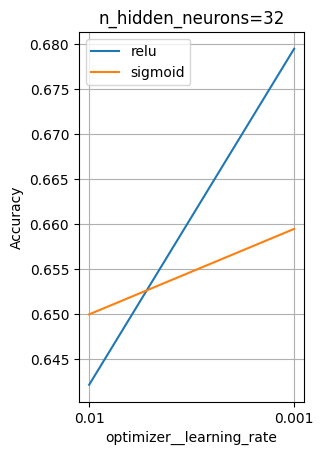

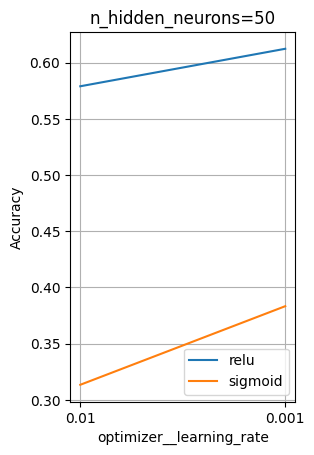

In [18]:
# Visualise the result of Hyperparameter tuning
param_grid = {
    "n_hidden_neurons": [32, 50],
    "optimizer__learning_rate": [0.01, 0.001],
    "activation_function": ["relu", "sigmoid"]
}
MLP_score = grid_search_mlp.cv_results_["mean_test_score"].reshape(len(param_grid["n_hidden_neurons"]), len(param_grid["optimizer__learning_rate"]), -1)
for i in range(len(param_grid["n_hidden_neurons"])):
  plt.subplot(1, len(param_grid["n_hidden_neurons"]), i+1)
  plt.title("n_hidden_neurons="+ str(param_grid["n_hidden_neurons"][i]))
  temp = MLP_score[i].T
  for j in range(len(param_grid["activation_function"])):
    plt.plot(range(len(param_grid["optimizer__learning_rate"])), temp[j], label = param_grid["activation_function"][j])
  plt.xlabel("optimizer__learning_rate")
  plt.ylabel("Accuracy")
  plt.xticks(range(len(param_grid["optimizer__learning_rate"])),param_grid["optimizer__learning_rate"])
  plt.legend()
  plt.grid(True)
  plt.show()

## Model 2 - Convolutional Neural Network

In [11]:
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier_cnn = KerasClassifier(build_cnn,
                                   n_hidden_layers=2,
                                   kernel_size=(3,3),
                                   strides=(1,1),
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__learning_rate=0.01,
                                   metrics=["accuracy"]
                                  )
param_grid = {
    "kernel_size": [(3,3),(2,2)],
    "strides":[(1,1),(2,2)],
    "optimizer__learning_rate": [0.1, 0.01, 0.001],
}

grid_search_cnn = GridSearchCV(keras_classifier_cnn, param_grid, cv=cvKFold, verbose=2)
grid_search_cnn.fit(X_train_norm, y_train, batch_size=128, epochs=20)

Streaming output truncated to the last 5000 lines.
43/43 [==============================] - 0s 1ms/step
[CV] END kernel_size=(3, 3), optimizer__learning_rate=0.1, strides=(1, 1); total time=   9.3s
Epoch 1/20
97/97 [==============================] - 1s 4ms/step - loss: 1.7447 - accuracy: 0.3321
Epoch 2/20
97/97 [==============================] - 0s 4ms/step - loss: 1.2344 - accuracy: 0.5347
Epoch 3/20
97/97 [==============================] - 0s 4ms/step - loss: 1.0608 - accuracy: 0.6167
Epoch 4/20
97/97 [==============================] - 0s 4ms/step - loss: 0.9664 - accuracy: 0.6510
Epoch 5/20
97/97 [==============================] - 0s 4ms/step - loss: 0.8754 - accuracy: 0.6898
Epoch 6/20
97/97 [==============================] - 0s 4ms/step - loss: 0.8855 - accuracy: 0.6848
Epoch 7/20
97/97 [==============================] - 0s 4ms/step - loss: 0.8246 - accuracy: 0.7069
Epoch 8/20
97/97 [==============================] - 0s 4ms/step - loss: 0.8088 - accuracy: 0.7148
Epoch 9/20
97/97 [

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KerasClassifier(kernel_size=(3, 3), loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function build_cnn at 0x7f1d8ea1cf70>, n_hidden_layers=2, optimizer='sgd', optimizer__learning_rate=0.01, strides=(1, 1)),
             param_grid={'kernel_size': [(3, 3), (2, 2)],
                         'optimizer__learning_rate': [0.1, 0.01, 0.001],
                         'strides': [(1, 1), (2, 2)]},
             verbose=2)

In [12]:
# The best parameters results and cross-validation accuracy
print("CNN best optimizer__learning_rate: {}".format(grid_search_cnn.best_params_['optimizer__learning_rate']))
print("CNN best kernel_size: {}".format(grid_search_cnn.best_params_['kernel_size']))
print("CNN best strides: {}".format(grid_search_cnn.best_params_['strides']))
print("CNN cross-validation accuracy: {:.4f}".format(grid_search_cnn.best_score_))

CNN best optimizer__learning_rate: 0.1
CNN best kernel_size: (3, 3)
CNN best strides: (2, 2)
CNN cross-validation accuracy: 0.7731


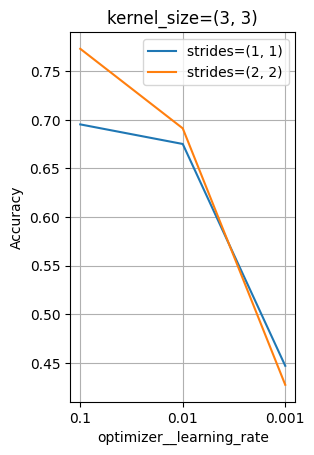

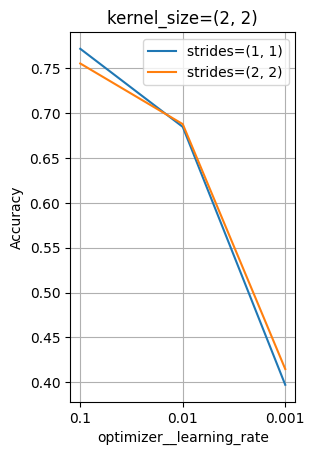

In [15]:
# Visualise the result of Hyperparameter tuning
CNN_score = grid_search_cnn.cv_results_["mean_test_score"].reshape(len(param_grid["kernel_size"]),
                                                                       len(param_grid["optimizer__learning_rate"]), -1)
for i in range(len(param_grid["kernel_size"])):
  plt.subplot(1, len(param_grid["kernel_size"]), i+1)
  plt.title("kernel_size="+str(param_grid["kernel_size"][i]))
  temp = CNN_score[i].T
  for j in range(len(param_grid["strides"])):
   plt.plot(range(len(param_grid["optimizer__learning_rate"])), temp[j], label ='strides='+ str(param_grid["strides"][j]))
  plt.xlabel("optimizer__learning_rate")
  plt.ylabel("Accuracy")
  plt.xticks(range(len(param_grid["optimizer__learning_rate"])),param_grid["optimizer__learning_rate"])
  plt.legend()
  plt.grid(True)
  plt.show()

## Model 3 - Algorithm Choice 1

In [44]:
# Hyperparameter tuning for Random Forest
cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

def bestRFClassifier(X,y):
    param_grid = {'n_estimators': [10, 30, 50, 100],
              'max_leaf_nodes': [10, 16, 20, 30]}
    grid_search = GridSearchCV(RandomForestClassifier(criterion='entropy',max_features = 'sqrt'), param_grid, cv=cvKFold,
                          return_train_score=True)
    grid_search.fit(X, y)

    return grid_search

param_grid = {'n_estimators': [10, 30, 50, 100],
              'max_leaf_nodes': [10, 16, 20, 30]}

# Train the RF model
grid_search_RF = bestRFClassifier(X_train_RF,y_train)

In [45]:
# The best parameters results and cross-validation accuracy
print("RF best n_estimators: {}".format(grid_search_RF.best_params_['n_estimators']))
print("RF best max_leaf_nodes: {}".format(grid_search_RF.best_params_['max_leaf_nodes']))
print("RF cross-validation accuracy: {:.4f}".format(grid_search_RF.best_score_))

RF best n_estimators: 100
RF best max_leaf_nodes: 30
RF cross-validation accuracy: 0.7268


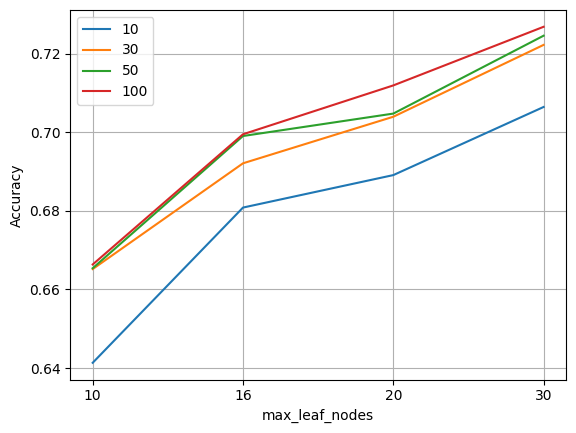

In [46]:
# Visualise the result of Hyperparameter tuning
RF_score = grid_search_RF.cv_results_["mean_test_score"].reshape(len(param_grid["max_leaf_nodes"]),-1).T
for i in range(len(param_grid["n_estimators"])):
  plt.plot(range(len(param_grid["max_leaf_nodes"])), RF_score[i], label = param_grid["n_estimators"][i])
plt.xlabel("max_leaf_nodes")
plt.ylabel("Accuracy")
plt.xticks(range(len(param_grid["max_leaf_nodes"])),param_grid["max_leaf_nodes"])
plt.legend()
plt.grid(True)
plt.show()

## Model 4 - Algorithm Choice 2

In [ ]:
# Linear SVM
# You should use SVC from sklearn.svm
C = [0.01, 0.1, 1, 10, 100]
gamma = [0.01, 0.1, 1, 10, 100]
def bestLinClassifier(X,y):
    param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(SVC(kernel = 'linear'), param_grid, cv=cvKFold,
                          return_train_score=True)
    grid_search.fit(X, y)
    return grid_search #(appropriate values so that the required printing can be done)

grid_search_SVM = bestLinClassifier(X_train_RF,y_train)

print("SVM best C: {}".format(grid_search_SVM.best_params_['C']))
print("SVM best gamma: {}".format(grid_search_SVM.best_params_['gamma']))
print("SVM cross-validation accuracy: {:.4f}".format(grid_search_SVM.best_score_))
print("SVM test set accuracy: {:.4f}".format(grid_search_SVM.score(X_test_RF, y_test)))

# Final Models

## Model 1 - Fully Connected Neural Network

In [24]:
#Best Full connected neural network model with optimizer__lr: 0.01, activation_function: relu
best_mlp_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])

# Compile model with MSE loss
opt = keras.optimizers.SGD(learning_rate=0.01)
best_mlp_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

best_mlp_model.fit(X_train_3d, y_train, epochs = 100)
loss, accuracy = best_mlp_model.evaluate(X_test_3d, y_test)
print("MLP test set accuracy: {:.4f}".format(accuracy))

Epoch 1/100
428/428 [==============================] - 1s 2ms/step - loss: 1.5373 - accuracy: 0.4030
Epoch 2/100
428/428 [==============================] - 1s 2ms/step - loss: 1.2016 - accuracy: 0.5401
Epoch 3/100
428/428 [==============================] - 1s 2ms/step - loss: 1.1136 - accuracy: 0.5799
Epoch 4/100
428/428 [==============================] - 1s 2ms/step - loss: 1.0531 - accuracy: 0.6014
Epoch 5/100
428/428 [==============================] - 1s 2ms/step - loss: 1.0039 - accuracy: 0.6225
Epoch 6/100
428/428 [==============================] - 1s 2ms/step - loss: 0.9762 - accuracy: 0.6354
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 0.9558 - accuracy: 0.6372
Epoch 8/100
428/428 [==============================] - 1s 2ms/step - loss: 0.9304 - accuracy: 0.6515
Epoch 9/100
428/428 [==============================] - 1s 2ms/step - loss: 0.9192 - accuracy: 0.6576
Epoch 10/100
428/428 [==============================] - 1s 2ms/step - loss: 0.8992 - accura

## Model 2 - Convolutional Neural Network

In [36]:
#Best CNN model with optimizer__lr: 0.1, kernel_size: (3, 3), strides: (2, 2)
best_cnn_model = keras.Sequential([
    keras.Input(shape=(28,28,1)),
    keras.layers.Conv2D(32, kernel_size= (3, 3),strides = (2, 2), activation = "relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size= (3, 3),strides = (2, 2), activation = "relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax"),
])

# Compile model with MSE loss
opt = keras.optimizers.SGD(learning_rate=0.1)
best_cnn_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=opt,
                       metrics=['accuracy'])

best_cnn_model.fit(X_train_3d, y_train, epochs = 100)
loss, accuracy = best_cnn_model.evaluate(X_test_3d, y_test)
print("CNN test set accuracy: {:.4f}".format(accuracy))

Epoch 1/100
428/428 [==============================] - 2s 3ms/step - loss: 1.6866 - accuracy: 0.3496
Epoch 2/100
428/428 [==============================] - 1s 3ms/step - loss: 1.2250 - accuracy: 0.5521
Epoch 3/100
428/428 [==============================] - 1s 3ms/step - loss: 1.0856 - accuracy: 0.6073
Epoch 4/100
428/428 [==============================] - 1s 3ms/step - loss: 0.9915 - accuracy: 0.6424
Epoch 5/100
428/428 [==============================] - 1s 3ms/step - loss: 0.9398 - accuracy: 0.6653
Epoch 6/100
428/428 [==============================] - 1s 3ms/step - loss: 0.9084 - accuracy: 0.6748
Epoch 7/100
428/428 [==============================] - 1s 3ms/step - loss: 0.8824 - accuracy: 0.6838
Epoch 8/100
428/428 [==============================] - 1s 3ms/step - loss: 0.8569 - accuracy: 0.6869
Epoch 9/100
428/428 [==============================] - 1s 3ms/step - loss: 0.8405 - accuracy: 0.6979
Epoch 10/100
428/428 [==============================] - 1s 3ms/step - loss: 0.8184 - accura

## Model 3 - Algorithm Choice 1

In [ ]:
#Best Random Forestc model with n_estimators = 100, max_leaf_nodes = 30
best_RF = RandomForestClassifier(criterion='entropy', n_estimators=100, max_leaf_nodes=30, random_state=0)
best_RF.fit(X_train_2d, y_train)
print("RF test set accuracy: {:.4f}".format(best_RF.score(X_test_2d, y_test)))

## Model 4 - Algorithm Choice 2